In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
import os

os.chdir("/content/gdrive/My Drive/controltext")
!nvidia-smi

Mounted at /content/gdrive/
Wed Dec 25 00:25:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+---------------------------------------

In [2]:
!pip install -r requirements.txt

In [46]:
#@title Step 1: Load Libraries and Weights
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import cv2
from tqdm import tqdm
import langid
from PIL import Image, ImageFont
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt  # Add this import statement at the beginning
from IPython.display import display, clear_output
import ipywidgets as widgets  # Interactive widgets for font selection
import sys
sys.path.append('.')  # Ensure we can import from local repo
from t3_dataset import T3DataSet, draw_glyph, draw_glyph2
from cldm.model import create_model, load_state_dict
import util
import random
import easyocr
from google.colab import files, output
output.enable_custom_widget_manager()
%matplotlib ipympl
from matplotlib.patches import Rectangle, Polygon

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ocr_reader = easyocr.Reader(['ch_sim', 'en']) # this needs to run only once to load the model into memory

model_config = './models_yaml/anytext_sd15.yaml'  # Path to your model config
resume_path = './models/lightning_logs/version_2/checkpoints/last.ckpt'  # Path to your trained model weights

# Load the model
model = create_model(model_config)
model.load_state_dict(load_state_dict(resume_path), strict=False)
model = model.to(device)
model.eval()


ControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_

ControlLDM(
  (model): DiffusionWrapper(
    (diffusion_model): ControlledUnetModel(
      (time_embed): Sequential(
        (0): Linear(in_features=320, out_features=1280, bias=True)
        (1): SiLU()
        (2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (input_blocks): ModuleList(
        (0): TimestepEmbedSequential(
          (0): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1-2): 2 x TimestepEmbedSequential(
          (0): ResBlock(
            (in_layers): Sequential(
              (0): GroupNorm32(32, 320, eps=1e-05, affine=True)
              (1): SiLU()
              (2): Conv2d(320, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
            (h_upd): Identity()
            (x_upd): Identity()
            (emb_layers): Sequential(
              (0): SiLU()
              (1): Linear(in_features=1280, out_features=320, bias=True)
            )
            (out_layers): Sequential(
       

In [48]:
#@title Step 2: Upload Image and Font
# Upload image
print("Please upload your image file (e.g., jpg, png).")
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Open and check the image size
image = Image.open(img_path).convert("RGB")
if image.size == (512, 512):
    print("Image size is already 512x512. No cropping or resizing needed.")
    processed_image = image
else:
    if image.size[0] != 512 or image.size[1] != 512:
        print("Image is not 512x512. Resizing to ensure the smaller edge is 512.")
        scale_factor = 512 / min(image.size)
        new_size = (int(image.size[0] * scale_factor), int(image.size[1] * scale_factor))
        image = image.resize(new_size, Image.LANCZOS)

        if new_size[0] != 512 or new_size[1] != 512:
            print("Proceed to the next cell for cropping.")
    image.save("resized_image.png")

# Save resized image for cropping
image.save("uploaded_image.png")


Please upload your image file (e.g., jpg, png).


Saving merlin_212276709_3104aef5-3dc4-4288-bb44-9e5624db0b37-superJumbo-1.jpg to merlin_212276709_3104aef5-3dc4-4288-bb44-9e5624db0b37-superJumbo-1.jpg
Image is not 512x512. Resizing to ensure the smaller edge is 512.
Proceed to the next cell for cropping.


In [49]:
upload_own_font = False
is_latin = True  # Change to False to load Chinese fonts

def on_font_select(change):
    global selected_font_path
    selected_font_path = os.path.join(font_dir_used, change['new'])
    print(f"Font selected: {selected_font_path}")

if upload_own_font:
    print("Please upload your TTF or TTC font file.")
    uploaded_font = files.upload()
    font_path = list(uploaded_font.keys())[0]
else:
    # Set the font directory paths
    fonts_dir = './fonts'
    chinese_fonts_dir = os.path.join(fonts_dir, 'chinese')

    # Ensure the directories exist
    if not os.path.exists(fonts_dir):
        os.makedirs(fonts_dir)
        print(f"Created a 'fonts' directory at {fonts_dir}. Please add font files here.")

    if not os.path.exists(chinese_fonts_dir):
        os.makedirs(chinese_fonts_dir)
        print(f"Created a 'chinese' subdirectory at {chinese_fonts_dir}. Please add Chinese font files here.")

    # Load fonts based on the selection
    if is_latin:
        available_fonts = [f for f in os.listdir(fonts_dir) if f.endswith(('.ttf', '.ttc', 'otf')) and os.path.isfile(os.path.join(fonts_dir, f))]
        font_dir_used = fonts_dir
    else:
        available_fonts = [f for f in os.listdir(chinese_fonts_dir) if f.endswith(('.ttf', '.ttc', 'otf')) and os.path.isfile(os.path.join(chinese_fonts_dir, f))]
        font_dir_used = chinese_fonts_dir

    font_dropdown = widgets.Dropdown(
        options=available_fonts,
        description='Select Font:',
        style={'description_width': 'initial'}
    )

    font_dropdown.observe(on_font_select, names='value')
    display(font_dropdown)

selected_font_path = os.path.join(font_dir_used, font_dropdown.value)
try:
    font = ImageFont.truetype(selected_font_path, size=40)
    print(f"Font '{font_dropdown.value}' successfully loaded.")
except Exception as e:
    print(f"Error loading font '{font_dropdown.value}': {e}")

print("Image and font saved. Proceed to the next cell to crop interactively.")

Dropdown(description='Select Font:', options=('Skia.ttf', 'Sathu.ttf', 'Shree714.ttc', 'Bodoni_72_Smallcaps_Bo…

Font 'Skia.ttf' successfully loaded.
Image and font saved. Proceed to the next cell to crop interactively.
Font selected: ./fonts/Times_New_Roman.ttf


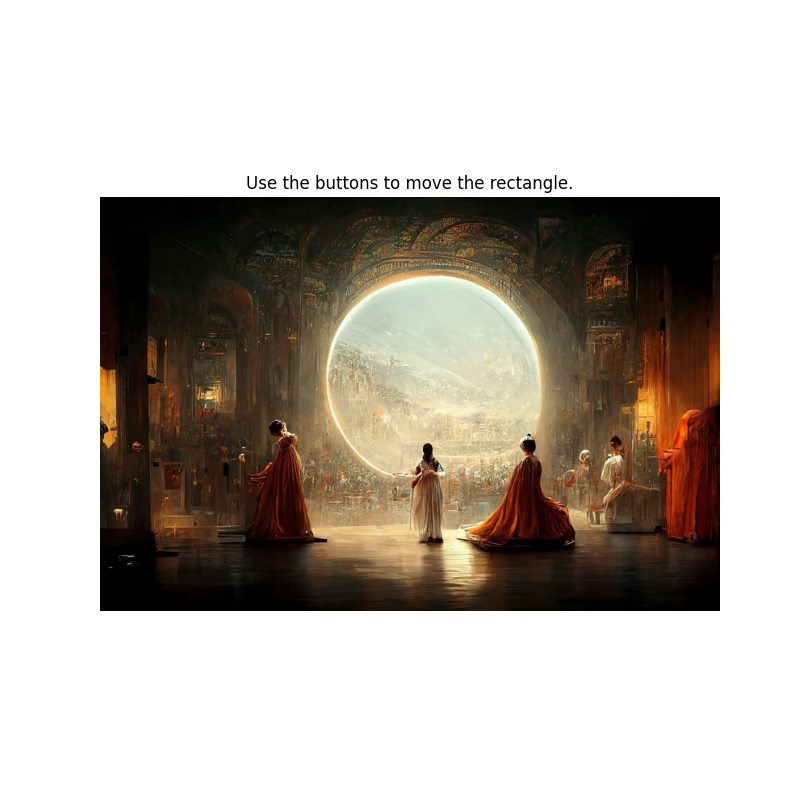

In [51]:
# Load the image
image = Image.open("resized_image.png")
if image.size == (512, 512):
    print("No need to crop the image")
else:
    # Initialize variables
    coords = [(0, 0), (512, 512)]  # Default rectangle coordinates
    rect = None  # Placeholder for the rectangle

    # Center the rectangle on the image by default
    image_center_x = image.size[0] // 2
    image_center_y = image.size[1] // 2
    x1 = image_center_x - 256
    y1 = image_center_y - 256
    x2 = image_center_x + 256
    y2 = image_center_y + 256
    coords = [(x1, y1), (x2, y2)]

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    ax.set_title("Use the buttons to move the rectangle.")
    ax.axis('off')

    # Function to draw the rectangle
    def draw_rectangle():
        global rect
        ax.clear()
        ax.imshow(image)
        ax.set_title("Use the buttons to move the rectangle.")
        ax.axis('off')
        x1, y1 = coords[0]
        x2, y2 = coords[1]
        rect = Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', lw=2)
        ax.add_patch(rect)
        plt.draw()

    # Function to move the rectangle
    def move_rectangle(direction):
        global coords

        step = 5  # Step size for movement
        x1, y1 = coords[0]
        x2, y2 = coords[1]

        if direction == 'up' and y1 - step >= 0:
            y1 -= step
            y2 -= step
        elif direction == 'down' and y2 + step <= image.size[1]:
            y1 += step
            y2 += step
        elif direction == 'left' and x1 - step >= 0:
            x1 -= step
            x2 -= step
        elif direction == 'right' and x2 + step <= image.size[0]:
            x1 += step
            x2 += step

        coords = [(x1, y1), (x2, y2)]
        draw_rectangle()

    # Determine which buttons are necessary
    buttons = []
    if image.size[0] > 512:
        button_left = widgets.Button(description="Left")
        button_right = widgets.Button(description="Right")
        button_left.on_click(lambda _: move_rectangle('left'))
        button_right.on_click(lambda _: move_rectangle('right'))
        buttons.extend([button_left, button_right])

    if image.size[1] > 512:
        button_up = widgets.Button(description="Up")
        button_down = widgets.Button(description="Down")
        button_up.on_click(lambda _: move_rectangle('up'))
        button_down.on_click(lambda _: move_rectangle('down'))
        buttons.extend([button_up, button_down])

    # Lay out the buttons dynamically
    button_box = widgets.VBox([
        widgets.HBox(buttons)
    ])

    # Display the buttons
    display(button_box)

    # Show the plot
    plt.show()


Displaying the cropped image:


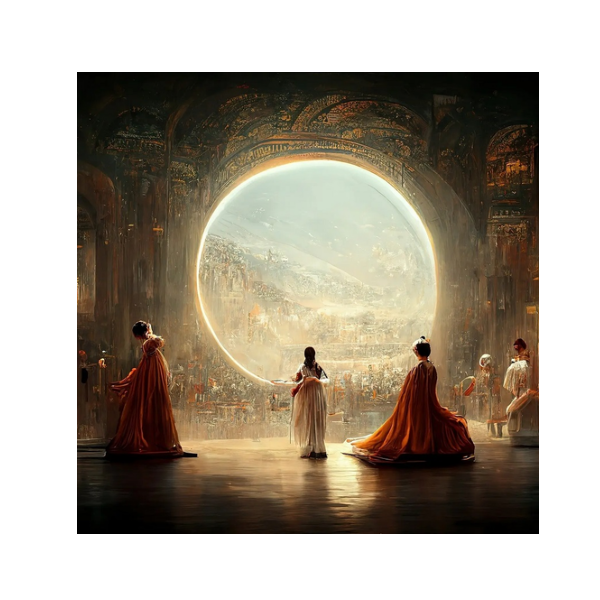

Cropping completed. The cropped image is saved as 'user_image_512x512.png'.


In [52]:
# Perform the cropping
x1, y1 = coords[0]
x2, y2 = coords[1]
cropped_image = image.crop((x1, y1, x2, y2)).resize((512, 512))

# Display the cropped image
print("Displaying the cropped image:")
plt.figure(figsize=(6, 6))
plt.imshow(cropped_image)
plt.axis('off')
plt.show()

# Save the cropped image
cropped_image.save("user_image_512x512.png")
print("Cropping completed. The cropped image is saved as 'user_image_512x512.png'.")

image = cropped_image

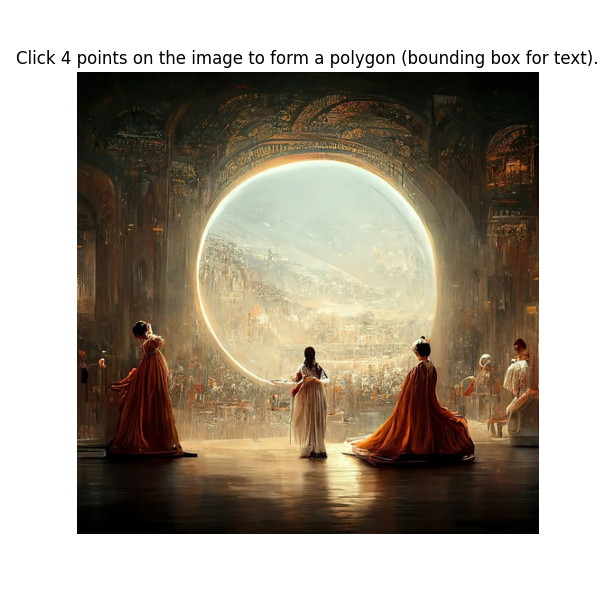

In [53]:
#@title Step 3: Draw the Masked Region
# Display the image and setup the figure
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image)
ax.set_title("Click 4 points on the image to form a polygon (bounding box for text).")
ax.axis('off')

coords = []

# Function to handle click events
def on_click(event):
    if event.inaxes == ax:
        # Record the coordinates
        coords.append((event.xdata, event.ydata))
        # Plot a red dot where the user clicked
        ax.plot(event.xdata, event.ydata, 'ro')
        fig.canvas.draw_idle()  # Redraw the canvas
        # If 4 points are collected, draw the polygon
        if len(coords) == 4:
            # Create a polygon with transparent red color
            polygon = Polygon(coords, closed=True, edgecolor='red', facecolor='red', alpha=0.3)
            ax.add_patch(polygon)
            fig.canvas.draw_idle()  # Update the canvas
        # Disconnect and close after the polygon is drawn
        if len(coords) > 4:
            fig.canvas.mpl_disconnect(cid)
            plt.close(fig)

# Connect the click event to the handler
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot
plt.show()


In [54]:
def sort_box_points(box):
    """
    Sorts the points of a box in the order:
    top-left, top-right, bottom-left, bottom-right.

    Args:
        box (numpy.ndarray): A 4x2 array of box points [[x1, y1], [x2, y2], [x3, y3], [x4, y4]].

    Returns:
        numpy.ndarray: Sorted points in the order [top-left, top-right, bottom-left, bottom-right].
    """
    # Ensure input is a NumPy array
    box = np.array(box, dtype=np.float32)

    # Sort points based on the sum of coordinates (x + y)
    sum_coords = np.sum(box, axis=1)
    top_left = box[np.argmin(sum_coords)]  # Smallest sum is top-left
    bottom_right = box[np.argmax(sum_coords)]  # Largest sum is bottom-right

    # Sort points based on the difference of coordinates (y - x)
    diff_coords = np.diff(box, axis=1).flatten()
    top_right = box[np.argmin(diff_coords)]  # Smallest difference is top-right
    bottom_left = box[np.argmax(diff_coords)]  # Largest difference is bottom-left

    # Return sorted points
    return np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)


# Check if 4 points were selected
if len(coords) != 4:
    raise ValueError("Four points were not selected. Please retry.")

# Convert points to polygon array as needed by the code
# The polygon should be a numpy array of shape (1,4,2), with coords in (x,y) form.
poly = np.array(coords, dtype=np.int32)
poly = sort_box_points(poly)
poly = np.expand_dims(poly, axis=0)  # shape (1,4,2)
poly = poly.astype(np.int32)

print("Polygon points selected:", poly)


Polygon points selected: [[[ 12  11]
  [502  11]
  [504 111]
  [  7 106]]]


In [55]:
#@title Step 4: Input Desired Text

text_input = widgets.Text(
    value='',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

display(text_input)

# Run this cell after you have typed the desired text in the box.


Text(value='', description='Text:', placeholder='Type something')

In [56]:
#@title Step 4: Input Desired Text

caption = widgets.Text(
    value='',
    placeholder='Type something',
    description='Caption:',
    disabled=False
)

display(caption)

# Run this cell after you have typed the desired text in the box.


Text(value='', description='Caption:', placeholder='Type something')

In [ ]:
#@title Step 4 Option 1: Load Glyphs
use_uploaded_glyph = True

# Upload image
print("Please upload your image file (e.g., jpg, png).")
from google.colab import files
uploaded = files.upload()
glyphs_path = list(uploaded.keys())[0]

# Open and possibly crop the image
glyphs = Image.open(glyphs_path).convert("RGB")
# image = interactive_crop(image)
image.save("user_glyph_1024x1024.png")
glyphs_path = "user_glyph_1024x1024.png"

glyphs = np.expand_dims(np.asarray(glyphs)[:, :, 0], axis=-1)
glyphs = glyphs.astype(float) / 255
print('glyphs', glyphs.shape, np.min(glyphs), np.max(glyphs))

Please upload your image file (e.g., jpg, png).


Saving book_glyph.png to book_glyph (8).png
glyphs (1024, 1024, 1) 0.0 1.0


In [57]:
#@title Step 4 Option 2: Draw Glyphs from Input Texts and Fonts
use_uploaded_glyph = False

selected_font_path ./fonts/Times_New_Roman.ttf texts ["Théâtre D'opéra Spatial"] caption Théâtre D'opéra Spatial


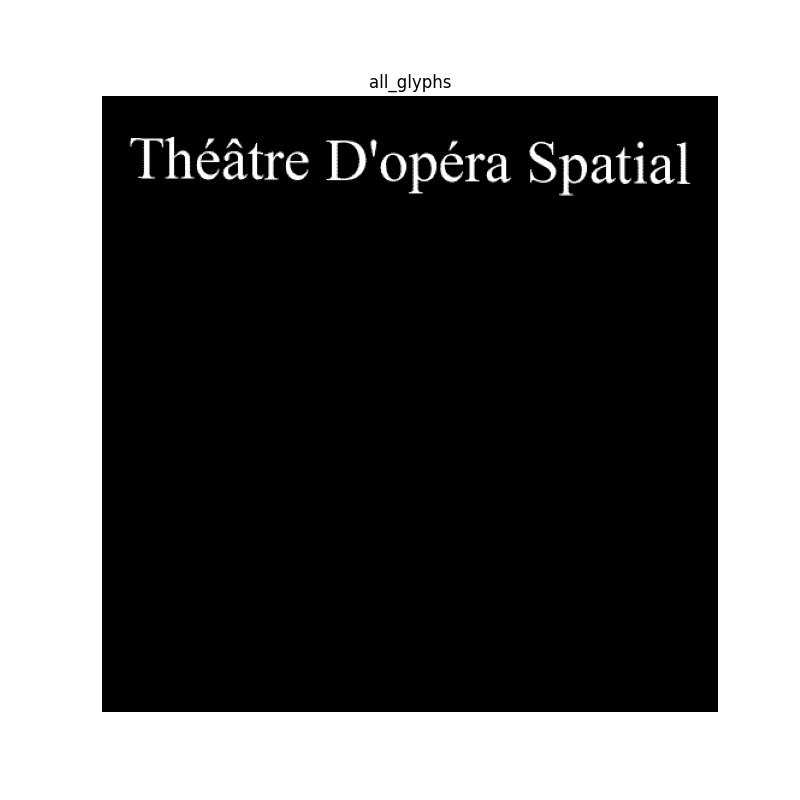

overlapping_boxes [array([[ 18,  25],
       [497,  25],
       [497,  89],
       [ 18,  89]])]
tightest_box [[ 18  25]
 [497  25]
 [497  89]
 [ 18  89]]


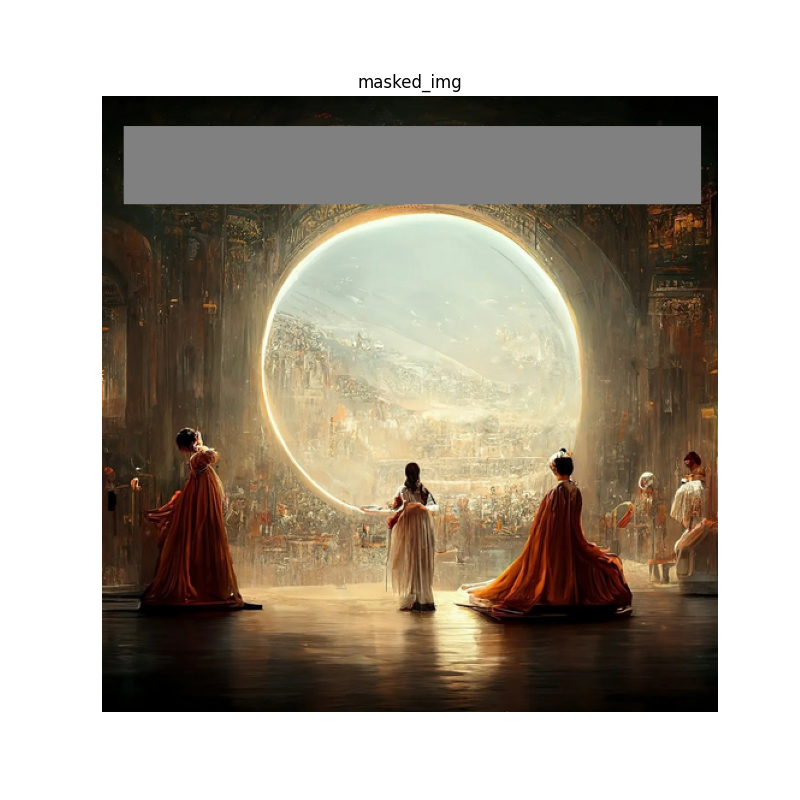

Prepared inputs for inference.


In [62]:
#@title Step 4 Process Glyphs
def run_ocr(ocr_reader, image_path):
    results = ocr_reader.readtext(image_path)
    boxes = []
    for i in range(len(results)):
        box = results[i][0]
        text = results[i][1]
        confidence = results[i][2]
        boxes.append(box)
        # print('box', box, 'text', text, 'confidence', confidence)
    return boxes


def draw_pos(ploygon, prob=1.0):
    img = np.zeros((512, 512))
    rect = cv2.minAreaRect(ploygon)
    w, h = rect[1]
    small = False
    if w < 20 or h < 20:
        small = True
    if random.random() < prob:
        pts = ploygon.reshape((-1, 1, 2))
        cv2.fillPoly(img, [pts], color=255)
        # 10% dilate / 10% erode / 5% dilatex2  5% erodex2
        random_value = random.random()
        kernel = np.ones((3, 3), dtype=np.uint8)
        if random_value < 0.7:
            pass
        elif random_value < 0.8:
            img = cv2.dilate(img.astype(np.uint8), kernel, iterations=1)
        elif random_value < 0.9 and not small:
            img = cv2.erode(img.astype(np.uint8), kernel, iterations=1)
        elif random_value < 0.95:
            img = cv2.dilate(img.astype(np.uint8), kernel, iterations=2)
        elif random_value < 1.0 and not small:
            img = cv2.erode(img.astype(np.uint8), kernel, iterations=2)
    img = img[..., None]
    return img / 255.


def get_hint(positions):
    if len(positions) == 0:
        return np.zeros((512, 512, 1))
    return np.sum(positions, axis=0).clip(0, 1)


def boxes_overlap(poly1, poly2):
    polygon1 = Polygon(poly1)
    polygon2 = Polygon(poly2)

    # Calculate the intersection and union areas
    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou > 0.5


def tighten_mask(ocr_reader, poly, glyph_path, img_path):
    tight_text_box = run_ocr(ocr_reader, glyph_path)[0]
    tight_text_box = np.array(tight_text_box) // 2
    bg_text_boxes = run_ocr(ocr_reader, img_path)

    # Extract the boxes that overlap with the poly drawn by the user
    overlapping_boxes = []
    for box in bg_text_boxes:
        box = sort_box_points(box)
        box = np.array(box)

        if boxes_overlap(poly, box):
            overlapping_boxes.append(np.array(box).astype(np.int32))

    overlapping_boxes.append(np.array(tight_text_box))
    print('overlapping_boxes', overlapping_boxes)

    # Merge all boxes into the tightest enclosing box
    all_points = np.vstack(overlapping_boxes)  # Stack all points from all boxes
    x_min, y_min = np.min(all_points, axis=0)  # Find the smallest x and y
    x_max, y_max = np.max(all_points, axis=0)  # Find the largest x and y

    # Create the tightest enclosing box
    tightest_box = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])
    tightest_box = sort_box_points(tightest_box).astype(np.int32)
    print('tightest_box', tightest_box)

    return tightest_box


# Once text is input, we prepare inputs similarly to the original prepare_custom_inputs.
user_text = text_input.value
user_caption = caption.value
texts = [user_text]

# Create a font object
img_path = 'user_image_512x512.png'
print('selected_font_path', selected_font_path, 'texts', texts, 'caption', user_caption)
font = ImageFont.truetype(selected_font_path, size=60)
fonts = [font]

# Identify language of the text line
language = []
for txt in texts:
    lang, _ = langid.classify(txt)
    language.append(lang)

polygons = [poly]
glyph_scale = 2
all_glyphs = np.zeros((1024, 1024))

gly_line = draw_glyph(font, user_text)
if not use_uploaded_glyph:
    glyphs = draw_glyph2(font, user_text, polygons[0], scale=glyph_scale)

all_glyphs += glyphs.squeeze(-1)
all_glyphs[all_glyphs > 0] = 1
all_glyphs = all_glyphs.astype(np.bool_).astype(np.uint8)*255

# Save all_glyphs
os.makedirs('./inference_output', exist_ok=True)
save_path = os.path.join('./inference_output', "all_glyphs.jpg")
cv2.imwrite(save_path, all_glyphs)

all_glyphs = cv2.resize(all_glyphs, (512, 512), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(8,8))
plt.imshow(all_glyphs, cmap='gray')
plt.title("all_glyphs")
plt.axis('off')
plt.show()


# Make the user-drawn box tighter around the input texts, but also consider surrounding texts within the whole box
polygons = [tighten_mask(ocr_reader, poly[0], glyph_path=save_path, img_path=img_path)]  # redefine polygon
positions = []
for polygon in polygons:
    positions += [draw_pos(polygon, 1)]
hint = get_hint(positions)

original_image = np.array(Image.open(img_path).convert('RGB'))
mask = get_hint(positions)
mask = np.expand_dims(mask, axis=-1) if mask.ndim == 2 else mask
masked_img = original_image * (1 - mask).astype(np.uint8) + 128 * mask.astype(np.uint8)
masked_img = np.clip(masked_img, 0, 255).astype(np.uint8)


plt.figure(figsize=(8,8))
plt.imshow(masked_img)
plt.title("masked_img")
plt.axis('off')
plt.show()

original_image = (original_image.astype(np.float32) / 255) - 0.5
masked_img = (masked_img.astype(np.float32) / 255) - 0.5

# Create item_dict for the dataset
item_dict = {
    "img": original_image,
    "img_path": img_path,
    "caption": user_caption,
    "texts": texts,
    "language": language,
    "polygons": polygons,
    "glyphs": [glyphs],
    "gly_line": [gly_line],
    "positions": positions,
    "hint": hint,
    "masked_img": masked_img,
    "inv_mask": original_image
}

print("Prepared inputs for inference.")


Image loaded ['user_image_512x512.png']
Starting inference...


  0%|          | 0/1 [00:00<?, ?it/s]

mask torch.Size([512, 512, 3])
masked_img before tensor(0.) tensor(1.)
masked_img after tensor(-1.) tensor(1.)
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 200 timesteps



DDIM Sampler: 100%|██████████| 200/200 [02:23<00:00,  1.39it/s]


['reconstruction', 'masked_image', 'control', 'img', 'glyph', 'conditioning', 'samples_cfg_scale_9.00']


100%|██████████| 1/1 [02:26<00:00, 146.54s/it]

Decoded image saved to decoded_image.png
Inference complete. Displayed the image outputs.


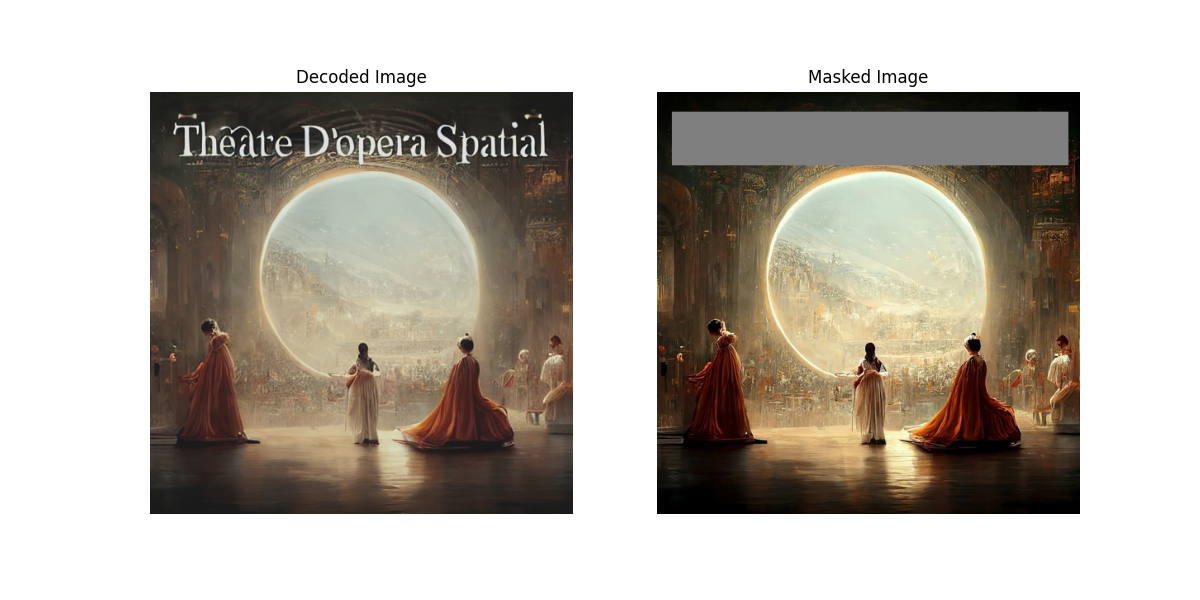

In [73]:
#@title Step 6: Run Inference

batch_size = 1
mask_ratio = 1
wm_thresh = 0.5
dataset_percent = 1.0

dataset = T3DataSet(
    item_dict["img_path"], max_lines=1, max_chars=20, caption_pos_prob=0.0,
    mask_pos_prob=1.0, mask_img_prob=mask_ratio, glyph_scale=2,
    percent=dataset_percent, debug=False, using_dlc=False, wm_thresh=wm_thresh,
    single_custom_image=True, custom_inputs=item_dict
)

dataloader = DataLoader(dataset, num_workers=1, persistent_workers=False, batch_size=batch_size, shuffle=False)

def inference(model, dataloader):
    print('Starting inference...')
    ddim_steps = 200

    for batch in tqdm(dataloader):
        mask = batch['positions'][0][0].repeat(1, 1, 3)
        print('mask', mask.shape)
        masked_img = batch['masked_img'][0]
        masked_img = (masked_img - torch.min(masked_img)) / (torch.max(masked_img) - torch.min(masked_img))
        print('masked_img before', torch.min(masked_img), torch.max(masked_img))
        masked_img[mask == 1] = 0.5
        masked_img = 2 * masked_img - 1
        masked_img = torch.clamp(masked_img, -1, 1)
        batch['masked_img'][0] = masked_img
        print('masked_img after', torch.min(masked_img), torch.max(masked_img))

        # Forward denoising process
        model.cond_stage_trainable = True
        log = model.log_images(batch, ddim_steps=ddim_steps, inpaint=True)
        print([key for key in log.keys()])

        decoded_sample = log['samples_cfg_scale_9.00']
        decoded_sample = decoded_sample[0].cpu().numpy()
        decoded_sample = (decoded_sample - np.min(decoded_sample)) / (np.max(decoded_sample) - np.min(decoded_sample))
        decoded_sample = np.transpose(decoded_sample, (1, 2, 0))

        # Save the decoded image
        decoded_image_path = "decoded_image.png"
        plt.imsave(decoded_image_path, decoded_sample)
        print(f"Decoded image saved to {decoded_image_path}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(decoded_sample)
        plt.title('Decoded Image')
        plt.axis('off')

        masked_img = (127.5 * (masked_img + 1).numpy()).astype(np.uint8)

        plt.subplot(1, 2, 2)
        plt.imshow(masked_img)
        plt.title('Masked Image')
        plt.axis('off')


inference(model, dataloader)
print("Inference complete. Displayed the image outputs.")
